# The Boolean pandemic

__Master Program DSAA    
Machine Learning 2020 - Group Project__

Group:

__Project Description__  

On January 1st, 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000 people at the end of February, with a mortality rate of more than 50%.  
While the conditions of the transmission of the virus is still unknown and there are no certainties of what leads a patient to survive or not to the virus, it seems there are some groups of people more prone to survive than others.
In this challenge, your goal is to build a predictive model that answers the question “What are the people more likely to survive to the boolean pandemic?” using the small quantity of data accessible of the patients – name, birthday date, severity of the disease, money of expenses associated to the treatment of each family, city and others.
As data scientists, your team is asked to analyze and transform as needed the data available and apply different models in order to answer in the more accurate way the defined question. Are you able to design a model that can predict if a patient will survive, or not, to the boolean pandemic?

__`Data fields`__

- **Patient_ID** - The unique identifier of the patient  
- **Family_Case_ID** - The family identification  
- **Severity** - The severity of the disease, where 1 is the lowest and 3 the highest severity  
- **Name** - The name of the patient  
- **Birthday_year** - The year of birthday of the patient  
- **Parents_Siblings_Infected** - The number of parents and/or siblings infected  
- **Partner_Children_Infected** - The number of partner and/or children infected  
- **Medical_Expenses_Family** - The medical expenses associated to try to contain the epidemy on the family  
- **Medical_Tent** - The medical tent where the patient is / was lodged  
- **City** - The original city of the patient  
  

__`Target`__
- **Deceased** - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)  

## 1. Import libraries

In [66]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
import re
from collections import Counter

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer, SimpleImputer, MissingIndicator
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

from tqdm import tqdm

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from xgboost import XGBClassifier

from pandas_profiling import ProfileReport
import category_encoders as ce

## 2. Import data

In [2]:
#read train data from csv file
df_train = pd.read_csv(r'train.csv')

In [3]:
#let's have a look at first 5 records
df_train.head().transpose()

,0,1,2,3,4
Patient_ID,1,2,3,4,5
Family_Case_ID,4696,21436,7273,8226,19689
Severity,3,1,3,3,3
Name,Miss Linda Betty,Ms. Ramona Elvira,Mr. Mario Vernon,Mr. Hector Joe,Ms. Jennie Debra
Birthday_year,NaN,1966,1982,1997,1994
Parents or siblings infected,0,0,0,0,0
Wife/Husband or children infected,0,1,0,0,0
Medical_Expenses_Family,225,1663,221,220,222
Medical_Tent,NaN,NaN,NaN,NaN,NaN
City,Santa Fe,Albuquerque,Santa Fe,Santa Fe,Santa Fe


In [4]:
#read test data from csv file
df_test = pd.read_csv(r'test.csv')

In [5]:
#let's have a look at first 5 records
df_test.head().transpose()

,0,1,2,3,4
Patient_ID,901,902,903,904,905
Family_Case_ID,49242,10400,10795,62440,81311
Severity,3,3,3,3,2
Name,Mr. Jody Pedro,Mr. Kevin Brent,Mr. Frankie Cary,Mr. Rick Pete,Mr. Matthew Erick
Birthday_year,NaN,1988,1981,NaN,1996
Parents or siblings infected,0,0,1,0,0
Wife/Husband or children infected,0,0,0,1,0
Medical_Expenses_Family,203,631,376,405,378
Medical_Tent,NaN,NaN,NaN,NaN,NaN
City,Santa Fe,Santa Fe,Albuquerque,Albuquerque,Santa Fe


## 3. Data pre-processing

### 3.1. Data Analysis

In [6]:
# Summary statistics for all variables 
def summary(dataframe):
    summary=dataframe.describe(include='all') 
    summary=summary.transpose()
    return summary.head(len(summary))

In [7]:
summary(df_train)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Patient_ID,900,NaN,NaN,NaN,450.5,259.952,1,225.75,450.5,675.25,900
Family_Case_ID,900,NaN,NaN,NaN,14305.8,25418.2,345,8203,13593.5,18906.5,742836
Severity,900,NaN,NaN,NaN,2.31333,0.834223,1,2,3,3,3
Name,900,899,Mr. Samuel Darnell,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birthday_year,723,NaN,NaN,NaN,1990.27,14.5233,1940,1982,1992,1999.5,2019
Parents or siblings infected,900,NaN,NaN,NaN,0.38,0.803247,0,0,0,0,6
Wife/Husband or children infected,900,NaN,NaN,NaN,0.521111,1.09839,0,0,0,1,8
Medical_Expenses_Family,900,NaN,NaN,NaN,895.743,1385.83,0,221,405,861.25,14345
Medical_Tent,198,8,C,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,898,3,Santa Fe,649,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         400 non-null    int64  
 1   Family_Case_ID                     400 non-null    int64  
 2   Severity                           400 non-null    int64  
 3   Name                               400 non-null    object 
 4   Birthday_year                      318 non-null    float64
 5   Parents or siblings infected       400 non-null    int64  
 6   Wife/Husband or children infected  400 non-null    int64  
 7   Medical_Expenses_Family            400 non-null    int64  
 8   Medical_Tent                       89 non-null     object 
 9   City                               400 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 31.4+ KB


In [9]:
#variables with null vallues
df_train.isna().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [10]:
#variables with null vallues
df_test.isna().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                         82
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         311
City                                   0
dtype: int64

#### Comments:
- We have 900 records in train dataset and 400 records on test dataset.  
- Both datasets have the same information, with the exception of target value that is missing on test dataset.  
- There some null values:
    - Train: Birthday_year, Medical_tent and City
    - Test: Birthday_year and Medical_tent

In [11]:
# pandas profiling is a cool feature for exploratory data analysis. More information here: https://github.com/pandas-profiling/pandas-profiling

profile = ProfileReport(df_train, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_widgets()

#### Comments:

- Birthday_year and Medical_Tent have the highest number of missing values (19.7% and 76.1% respectively)  
- We have 900 records and 0 duplicate rows  
- Variables Patient_ID, Family_Case_ID and Name are likely to be dropped or used for feature engineering  
- There are two records without City information, since Santa Fe is largely the most frequent city it seems reasonable to assume those two records as from Santa Fe.

__`Target variable - 'Deceased'`__

Let's have a look at the distribution of variables among deceased and survivors.

In [12]:
df_train.groupby(by="Deceased").mean().transpose()

Deceased,0,1
Patient_ID,449.423631,451.175407
Family_Case_ID,13619.536023,14736.466546
Severity,1.962536,2.533454
Birthday_year,1991.698305,1989.280374
Parents_or_siblings_infected,0.463977,0.327306
Wife/Husband_or_children_infected,0.475504,0.549729
Medical_Expenses_Family,1340.755043,616.504521


In [13]:
deceased_temp = df_train[df_train.Deceased == 1]
survived_temp = df_train[df_train.Deceased == 0]

Text(0, 0.5, 'Frequency')

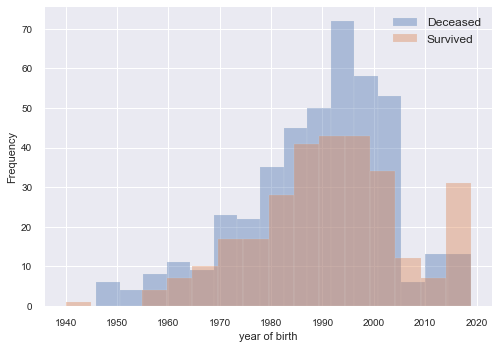

In [14]:
sns.distplot(deceased_temp['Birthday_year'], kde = False, label='Deceased')
sns.distplot(survived_temp['Birthday_year'], kde = False, label='Survived')

plt.legend(prop={'size': 12})
plt.xlabel('year of birth')
plt.ylabel('Frequency')

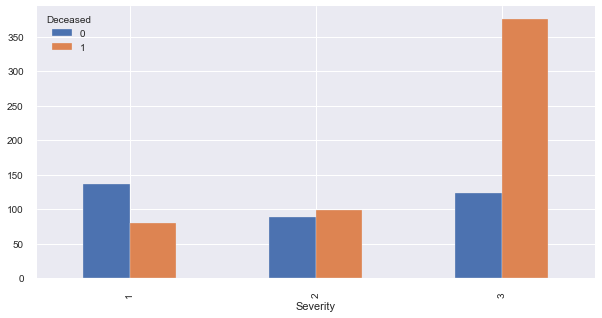

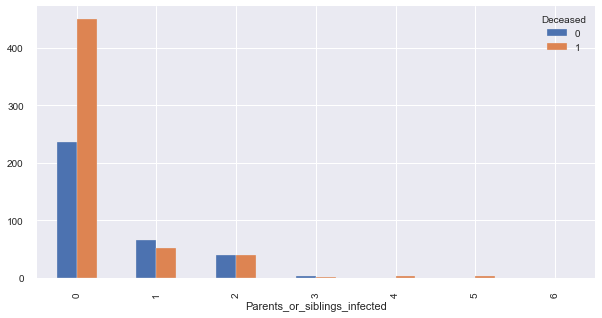

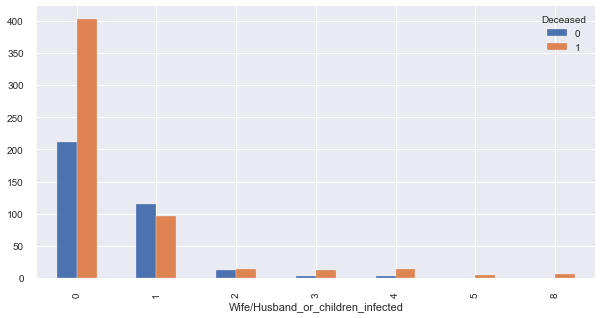

In [15]:
#let's have a look at some variables distribution per deceased
columns = ['Severity', 'Parents_or_siblings_infected', 'Wife/Husband_or_children_infected']

for col in columns:
    pd.crosstab(df_train[col],df_train.Deceased).plot(kind='bar',
                                          figsize=(10,5))

__`Medical Tent`__

In [16]:
def perc_table(index, columns, values):
    perc_table = pd.crosstab(index = index, 
                     columns = columns, 
                     values = values, 
                     aggfunc='count', margins = True,
                     normalize='columns').applymap('{:.3%}'.format)
    return perc_table

In [17]:
perc_table(df_train.Medical_Tent, df_train.City, df_train.index)

City,Albuquerque,Santa Fe,Taos,All
Medical_Tent,,,,
A,10.145%,6.504%,0.000%,7.653%
B,31.884%,17.886%,0.000%,22.449%
C,30.435%,27.642%,50.000%,29.082%
D,18.841%,14.634%,0.000%,15.816%
E,7.246%,20.325%,25.000%,15.816%
F,1.449%,8.943%,25.000%,6.633%
G,0.000%,3.252%,0.000%,2.041%
T,0.000%,0.813%,0.000%,0.510%


#### Comments:
From the table above we can observe that there are no rules we can establish for the Medical tents locations that could help us populate the missing values.  
Since we don't have enough information we have two possibilities:
- drop the column,
- fill missing values with No_tent.

__`Name`__

In [18]:
print(df_train.Name.str.split(' ').str[0].unique())

['Miss' 'Ms.' 'Mr.' 'Master']


#### Comments:
All records have name filled in and all start by either 'Miss', 'Ms.', 'Mr.' or 'Master. This information is quite useful to generate a new field Gender!

### 3.2. Data Manipulation

In [19]:
X = df_train.drop('Deceased', axis = 1)
y = df_train['Deceased']

In [20]:
df_test_copy = df_test.copy(deep=True)

### 3.2.1. Missing values

In [21]:
# fill in medical tent 
X['Medical_Tent'].fillna('No_tent', inplace = True)

In [22]:
df_test_copy['Medical_Tent'].fillna('No_tent', inplace = True)

In [23]:
#Fill in birthday year

imputer = SimpleImputer(strategy='mean').fit(X.loc[:,['Birthday_year']])

X.loc[:,'Birthday_year'] = imputer.transform(X.loc[:,['Birthday_year']]).astype(int)

In [24]:
df_test_copy.loc[:,'Birthday_year'] = imputer.transform(df_test_copy.loc[:,['Birthday_year']]).astype(int)

In [25]:
#Fill in city

X['City'].fillna('Santa Fe', inplace = True)

### 3.2.2. Feature Engineering

__`Gender`__

In [26]:
gender_dict ={'Miss' : 'F', 'Ms.' : 'F', 
                    'Mr.' : 'M', 'Master' : 'M'} 

X['Gender'] = X.Name.str.split(' ').str[0].map(gender_dict) 

In [27]:
df_test_copy['Gender'] = df_test_copy.Name.str.split(' ').str[0].map(gender_dict) 

__`Family Death ratio`__

In [28]:
temp_group = df_train.groupby('Family_Case_ID')
X['number_family_cases'] = temp_group['Patient_ID'].transform('count')
X['number_family_deaths'] = temp_group['Deceased'].transform(sum)
X['family_death_ratio'] = X['number_family_deaths']/ X['number_family_cases']

X.drop(['number_family_cases', 'number_family_deaths'], axis = 1, inplace=True)

In [29]:
df_test_copy = df_test_copy.merge(X[['family_death_ratio', 'Family_Case_ID']], how = 'left',
                left_on = 'Family_Case_ID', right_on = 'Family_Case_ID')

In [30]:
df_test_copy['family_death_ratio'].fillna(0, inplace = True)

__`Expenses per person (pp)`__

In [31]:
X['Expenses_pp'] = X['Medical_Expenses_Family'] / (X['Parents_or_siblings_infected'] + X['Wife/Husband_or_children_infected'] + 1)

In [32]:
df_test_copy['Expenses_pp'] = df_test_copy['Medical_Expenses_Family'] / (df_test_copy['Parents or siblings infected'] + df_test_copy['Wife/Husband or children infected'] + 1)

In [33]:
X.drop('Medical_Expenses_Family', axis = 1, inplace=True)

In [34]:
df_test_copy.drop('Medical_Expenses_Family', axis = 1, inplace=True)

__`Encoding`__

In [35]:
# Encode categorical variables to dummy variables
cat_features=['Medical_Tent', 'City', 'Gender']

ce_one_hot = ce.OneHotEncoder(cols = cat_features, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [36]:
df_test_copy = ce_one_hot.fit_transform(df_test_copy)

__`Drop Columns`__

In [45]:
cols_drop = ['Patient_ID','Family_Case_ID','Name', 
             'Medical_Tent_G', 'City_Taos','Gender_M']

In [46]:
X.drop(columns = cols_drop, inplace = True)
df_test_copy.drop(columns = cols_drop, inplace = True)

### 3.3. Train test split

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2, 
                                                  stratify = y,
                                                  random_state = 15)

### 3.4 Feature Selection

### 3.4.1. Correlation

In [48]:
def cor_heatmap(cor):
    mask = np.triu(np.ones_like(cor, dtype=bool))
    plt.figure(figsize=(14,12))
    sns.set(font_scale=1.4, style = 'white')
    sns.heatmap(data = cor, annot = True, annot_kws={"size": 10},
                mask = mask, cmap = plt.cm.Reds, fmt='.1f')
    plt.show()

In [49]:
temp_X = X_train.copy(deep=True)
temp_X['target'] = y_train

In [50]:
corr_spearman = temp_X.corr('spearman')

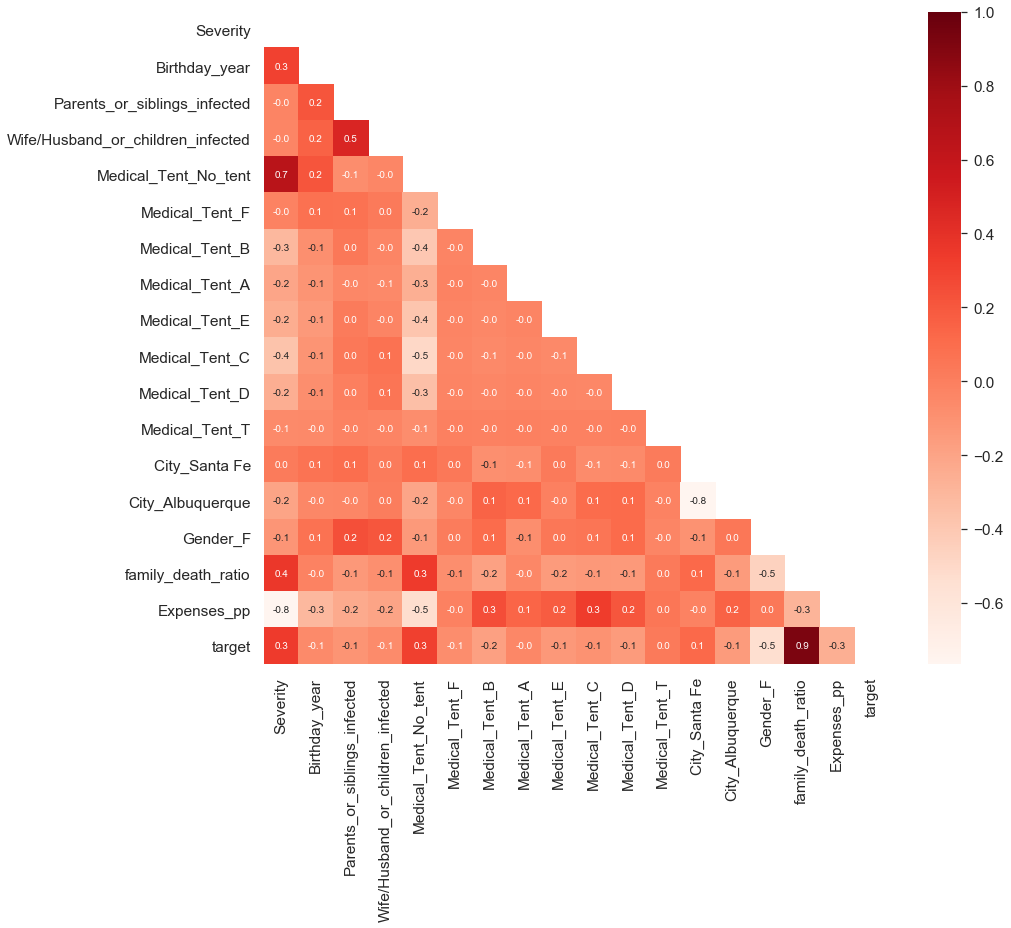

In [51]:
cor_heatmap(corr_spearman)

### 3.4.2. Lasso

In [52]:
lasso = LassoCV()
lasso.fit(X = X_train, y = y_train)
print("Best alpha using built-in LassoCV: %f" % lasso.alpha_)

Best alpha using built-in LassoCV: 0.102916


In [53]:
coef_lasso = pd.Series(lasso.coef_,index=X.columns)
coef_lasso

Severity                             0.000000
Birthday_year                       -0.002631
Parents_or_siblings_infected        -0.000000
Wife/Husband_or_children_infected    0.000000
Medical_Tent_No_tent                 0.000000
Medical_Tent_F                      -0.000000
Medical_Tent_B                      -0.000000
Medical_Tent_A                      -0.000000
Medical_Tent_E                      -0.000000
Medical_Tent_C                      -0.000000
Medical_Tent_D                      -0.000000
Medical_Tent_T                       0.000000
City_Santa Fe                        0.000000
City_Albuquerque                    -0.000000
Gender_F                            -0.000000
family_death_ratio                   0.451905
Expenses_pp                         -0.000073
dtype: float64

In [54]:
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso == 0)) + " variables")

Lasso picked 3 variables and eliminated the other 14 variables


In [55]:
# plot the scores
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

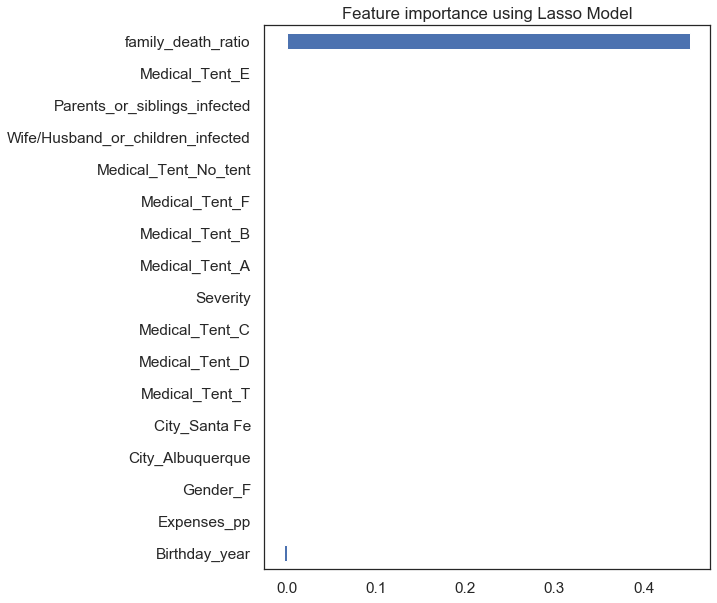

In [56]:
plot_importance(coef_lasso,'Lasso')

In [57]:
# Extracting important features according to Lasso Regression

lasso_features = coef_lasso.sort_values().abs() > lasso.alpha_
lasso_features = lasso_features[lasso_features].index.values
lasso_features

array(['family_death_ratio'], dtype=object)

### 3.4.3. RFE_CV

In [58]:
rf_clf = RandomForestClassifier(random_state = 15)
rf_clf.fit(X_train, y_train)

rfecv = RFECV(rf_clf, cv= 5, step=1)
rfecv = rfecv.fit(X_train, y_train)

rfecv_mask = rfecv.get_support() 

rfecv_features = [] 

for bool, feature in zip(rfecv_mask, X_train.columns):
    if bool:
        rfecv_features.append(feature)
        
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', rfecv_features)

Optimal number of features : 4
Best features : ['Birthday_year', 'Gender_F', 'family_death_ratio', 'Expenses_pp']


In [59]:
coef_rfecv = pd.Series(rf_clf.feature_importances_,index=X.columns)
coef_rfecv

Severity                             0.033070
Birthday_year                        0.055183
Parents_or_siblings_infected         0.012006
Wife/Husband_or_children_infected    0.015507
Medical_Tent_No_tent                 0.018747
Medical_Tent_F                       0.001480
Medical_Tent_B                       0.003410
Medical_Tent_A                       0.001009
Medical_Tent_E                       0.002228
Medical_Tent_C                       0.002435
Medical_Tent_D                       0.001996
Medical_Tent_T                       0.000138
City_Santa Fe                        0.006000
City_Albuquerque                     0.004181
Gender_F                             0.114537
family_death_ratio                   0.684636
Expenses_pp                          0.043437
dtype: float64

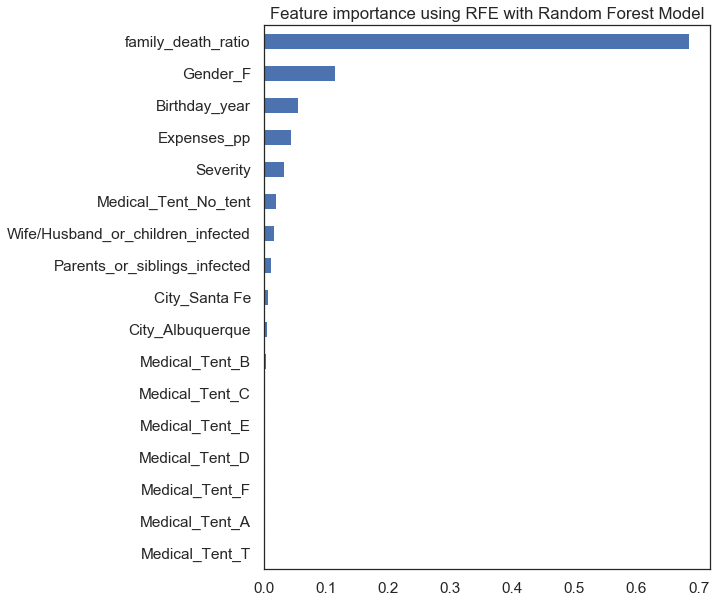

In [60]:
plot_importance(coef_rfecv,'RFE with Random Forest')

__`Selected Features`__

In [ ]:
#Set 
#cols_drop = ['Patient_ID','Family_Case_ID','Name',
#             'Medical_Expenses_Family', 'Medical_Tent_G', 'City_Taos',
#             'Gender_M']

In [ ]:
#X_train.drop(columns = cols_drop, inplace = True)
#X_val.drop(columns = cols_drop, inplace = True)

In [ ]:
#df_test_copy.drop(columns = cols_drop, inplace = True)

## 4. Model Implementation

### Model A - XGBoost

In [71]:
mod_A_pipe = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        (
            'classifier', BaggingClassifier(
                base_estimator= XGBClassifier(
                    colsample_bytree = 1.0, 
                    eta = 0.63, 
                    max_depth = 2),
                n_estimators=10,
                max_features=1.0,
                bootstrap=True,
                random_state = 15)
        )
    ]
)

In [72]:
mod_A_param_grid = {
    'scaler': [
        MinMaxScaler(), 
        MinMaxScaler(feature_range=(-1,1)),
        RobustScaler(),
        StandardScaler(),
        PowerTransformer()
    ],
    'classifier__n_estimators': list(np.arange(5,50,1)),
    'classifier__max_features': list(np.arange(2,9,1)),
    'classifier__bootstrap': [True, False],
    
}

In [73]:
#to be able to excatly reproduce the values we want to fix the seed, thus we initiate the Kfold for the GridSearch separetly and as follow:
kfold = KFold(n_splits = 5, random_state = 15)

In [74]:
mod_A_clf = GridSearchCV(
    mod_A_pipe, 
    mod_A_param_grid, 
    cv = kfold, 
    verbose = 2,
    n_jobs = -1,
    return_train_score=True,
    scoring='accuracy'
)

In [75]:
mod_A = mod_A_clf.fit(X, y)

Fitting 5 folds for each of 3150 candidates, totalling 15750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [76]:
mod_A.best_params_

{'classifier__bootstrap': True,
 'classifier__max_features': 8,
 'classifier__n_estimators': 44,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}

In [77]:
print('Mean: ', mod_A.cv_results_['mean_test_score'][mod_A.best_index_])
print('Split 1: ', mod_A.cv_results_['split0_test_score'][mod_A.best_index_])
print('Split 2: ', mod_A.cv_results_['split1_test_score'][mod_A.best_index_])
print('Split 3: ', mod_A.cv_results_['split2_test_score'][mod_A.best_index_])
print('Split 4: ', mod_A.cv_results_['split3_test_score'][mod_A.best_index_])
print('Split 5: ', mod_A.cv_results_['split4_test_score'][mod_A.best_index_])

Mean:  0.97
Split 1:  0.9833333333333333
Split 2:  0.9611111111111111
Split 3:  0.9611111111111111
Split 4:  0.9722222222222222
Split 5:  0.9722222222222222


**Prediction**

In [78]:
mod_A_labels_predict = mod_A.predict(df_test_copy)

In [80]:
labels_df_A = pd.DataFrame(data = mod_A_labels_predict)

In [81]:
df_test['Deceased'] = labels_df_A

In [83]:
#export to csv according to sample
df_test.to_csv('m20190876_v1.csv',columns=['Patient_ID','Deceased'],index=False)

### Model B - Decision Tree

In [ ]:
mod_B_clf = DecisionTreeClassifier(random_state=15)
path = mod_B_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    mod_B_clf = DecisionTreeClassifier(random_state=15, ccp_alpha=ccp_alpha)
    mod_B_clf.fit(X_train, y_train)
    clfs.append(clf)

### Model C - Neural Network

### Model D - KNN

### Model E - SVM

## 5. Performance Comparison and Final Thoughts